<a href="https://colab.research.google.com/github/Hangyeol82/AI_lab/blob/main/homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 과제

In [6]:
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset
from torchaudio.transforms import Resample, MelSpectrogram, AmplitudeToDB, MFCC

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.8.0+cu126
2.8.0+cu126
cuda


In [7]:
# 대사: and maybe I'll just wait on a drink for now
audio = torchaudio.load("sample.mov")

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

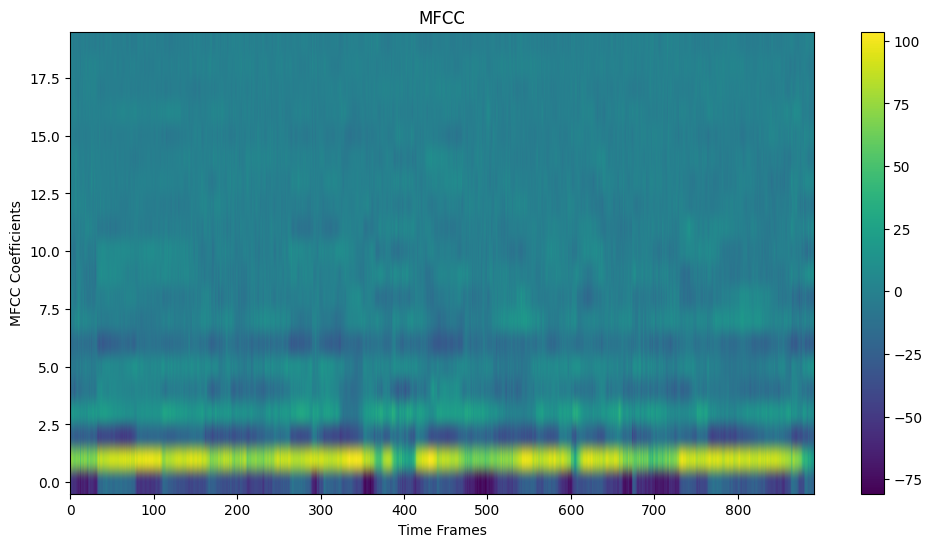

In [11]:
# waveform: Tensor [채널, 시간], sample_rate: int
waveform, sample_rate = sample

# MFCC 변환기 정의
mfcc_transform = MFCC(
    sample_rate=sample_rate,
    n_mfcc=20,  # 추출할 MFCC 계수 개수 (n_mels 이하로 조정)
    melkwargs={
        "n_fft": 400,       # FFT 윈도우 크기
        "hop_length": 160,  # 프레임 간격 (10ms @16kHz)
        "n_mels": 23,       # 멜 밴드 수
        "center": False,
    },
)

# MFCC 특징 추출
mfcc = mfcc_transform(waveform)  # [채널, n_mfcc, time]

plt.figure(figsize=(12, 6))
plt.imshow(mfcc[0].detach().numpy(), origin="lower", aspect="auto")
plt.title("MFCC")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) audio 튜플 사용
waveform, sample_rate = sample  # audio = torchaudio.load("sample.mov")

# 2) 모노로 변환 (여러 채널이면 평균)
if waveform.dim() == 2 and waveform.size(0) > 1:
    waveform = waveform.mean(dim=0, keepdim=True)  # (1, T)

# 3) 파이프라인(사전학습 모델) 준비
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H  # LibriSpeech 960h(영어)
model = bundle.get_model().to(device).eval()          # 가중치 자동 다운

# 4) 샘플레이트 맞추기 (모델은 16kHz 기대)
target_sr = bundle.sample_rate  # 16000
if sample_rate != target_sr:
    resampler = Resample(orig_freq=sample_rate, new_freq=target_sr)
    waveform = resampler(waveform)
    sample_rate = target_sr

# 5) 배치 차원 추가 + 디바이스
waveform = waveform.to(device)

# 6) 모델 추론 (emissions = 시점별 라벨 로짓)
with torch.inference_mode():
    emissions, _ = model(waveform)   # shape: (batch=1, time, num_labels)

# 7) Greedy decoding (튜토리얼과 동일 개념)
labels = bundle.get_labels()         # ('-', '|', 'E', 'T', 'A', ...)
blank_id = labels.index('-')

def greedy_decode(emissions, labels, blank_id):
    # emissions: (1, time, num_labels)
    # time축에서 argmax → 반복/blank 제거 → '|'를 공백으로 치환
    tokens = emissions.argmax(dim=-1)[0].tolist()
    prev = blank_id
    out = []
    for t in tokens:
        if t != prev and t != blank_id:
            out.append(labels[t])
        prev = t
    text = ''.join(out).replace('|', ' ').strip()
    return text

transcript = greedy_decode(emissions, labels, blank_id)
print("TRANSCRIPT:", transcript)

TRANSCRIPT: AND MAYBE I'LL JUST WAIT ON A DRINK CRENOL
